In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.preprocessing import PowerTransformer, OneHotEncoder
from sklearn.preprocessing import StandardScaler, Normalizer
from functools import wraps
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.experimental import enable_iterative_imputer
from imblearn.over_sampling import SMOTE
import warnings
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.impute import IterativeImputer
from geopy.geocoders import Nominatim
from geopy import distance
from countryinfo import CountryInfo

c:\Users\Yuval\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## 1 - Build Class Models


In [3]:
def validate_shapes(X, y):
    # if data is a pandas dataframe, we convert it to a numpy array
    if isinstance(X, pd.DataFrame) or isinstance(X, pd.Series):
        X = X.values
    if isinstance(y, pd.DataFrame) or isinstance(y, pd.Series):
        y = y.values
    if X.ndim == 1:
        X = X.reshape(-1, 1)
    if y.ndim != 1:
        y = y.reshape(-1)
    if X.shape[0] != y.shape[0]:
        raise Exception('X and y have different sizes.')
    return X, y

# build class for Simple Linear Regression
class SimpleLinearRegression:
    def __init__(self):
        self.coeff = None
        self.intercept = None


    def fit(self, X, y):
        # We validate the shapes of X and y
        X,y = validate_shapes(X, y)  
            
        # We add a column of 1s which will be used to calculate the intercept
        ones = np.ones(shape=X.shape[0]).reshape(-1, 1)
        X = np.concatenate((ones, X), 1)

        # We calculate the coefficients using the normal equation
        X_transpose = X.transpose()
        self.coeff = np.linalg.inv(X_transpose.dot(X)).dot(X_transpose).dot(y)

        # The first coefficient is the intercept, the rest of the coefficients are the beta values
        self.intercept = self.coeff[0]
        self.coeff = self.coeff[1:]
        

    def predict(self, X):
        if self.coeff is None or self.intercept is None:
            raise Exception('Model is not fitted yet. Run fit method before prediction.')
        
        return X.dot(self.coeff) + self.intercept
    
class myLogisticRegression:

    def __init__(self, lr = 0.01, num_iter = 100000, random_state = 2023):
        self.lr = lr
        self.num_iter = num_iter
        self.weights_ = None
        self.bias_ = None
        self.random_state = random_state
        np.random.seed(self.random_state)
        
    def get_params(self, deep=True):
        return {"lr": self.lr, "num_iter": self.num_iter, "random_state": self.random_state}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self
    
    def fit(self, X, y):
        # Check that X and y have correct shape
        X, y = check_X_y(X, y)
        
        n_samples, n_features = X.shape
        
        self.weights_ = np.zeros(n_features)
        self.bias_ = 0
        
        for _ in range(self.num_iter):
            linear_model = np.dot(X, self.weights_) + self.bias_
            y_predicted = self._sigmoid(linear_model)
            
            dw = (1 / n_samples) * np.dot(X.T, (y_predicted - y))
            db = (1 / n_samples) * np.sum(y_predicted - y)
            
            self.weights_ -= self.lr * dw
            self.bias_ -= self.lr * db
            
        return self  

    def predict(self, X):
        # Check is fit had been called
        check_is_fitted(self)
        
        # Input validation
        X = check_array(X)
        
        linear_model = np.dot(X, self.weights_) + self.bias_
        y_predicted = self._sigmoid(linear_model)
        y_predicted_cls = np.array([1 if i > 0.5 else 0 for i in y_predicted])
        return y_predicted_cls

    def predict_proba(self, X):
        # Check is fit had been called
        check_is_fitted(self)

        # Input validation
        X = check_array(X)
        
        linear_model = np.dot(X, self.weights_) + self.bias_
        y_predicted = self._sigmoid(linear_model)
        
        # Compute the complement probabilities, i.e., 1 - p
        complement_proba = 1 - y_predicted

        # Stack together for each sample
        return np.vstack((complement_proba, y_predicted)).T

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
        
            
    def _sigmoid(self,x):
        return 1/(1+np.exp(-x))
         
class PCA:
    def __init__(self, n_components, eps=1e-10):
        self.n_components = n_components
        self.components = None
        self.eigenvalues = None
        self.eps = eps  # small constant value to avoid division by zero
        
    def fit(self, X):
        # Scaling the data
        X = X - np.mean(X, axis=0)
        X = X / (np.std(X, axis=0) + self.eps)  # add small constant in the denominator
    
        # Compute covariance
        cov = np.cov(X.T)
        cov = (cov + cov.T) / 2 # Symmetric matrix

        # Eigenvalues, eigenvectors
        eigenvalues, eigenvectors = np.linalg.eigh(cov)

        # Sort eigenvectors
        eigenvectors = eigenvectors.T
        idxs = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[idxs]
        eigenvectors = eigenvectors[idxs]

        # Store first n eigenvectors
        self.components = eigenvectors[0:self.n_components]
        self.eigenvalues = eigenvalues

    def transform(self, X):
        X = X - np.mean(X, axis=0)
        X = X / (np.std(X, axis=0) + self.eps) # Scaling the data
        return np.dot(X, self.components.T)


    def plot_scree(self, n_components_plot=None):
        # Calculate the percentage of variance each component accounts for
        var_percentages = self.eigenvalues / sum(self.eigenvalues)

        # Cumulative variance percentages (summing upward)
        var_percentages_cumulative = np.cumsum(var_percentages)

        if n_components_plot is not None:
            var_percentages = var_percentages[:n_components_plot]
            var_percentages_cumulative = var_percentages_cumulative[:n_components_plot]

        plt.figure(figsize=(10, 6))
        bars = plt.bar(range(1, len(var_percentages) + 1), var_percentages)
        plt.plot(range(1, len(var_percentages_cumulative) + 1), var_percentages_cumulative, color='r', marker='o')

        # Adding the variance percentage on top of each bar
        for i, bar in enumerate(bars):
            yval = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval*100, 2), ha='center', va='bottom')

        plt.xlabel('Principal Components')
        plt.ylabel('Percentage of Variance Explained')
        plt.title('Scree Plot')
        plt.show()



## 2. Validate Models - Compare to sklearn models

### 2.1 Import Data

In [4]:
import pandas as pd
import numpy as np

train_data = pd.read_csv('train.csv')

# remove NaN values
print("Number of rows before removing NaN values: ",len(train_data))
train_data = train_data.dropna()
# number of rows before removing NaN values
print("Number of rows after removing NaN values: ",len(train_data))
train_data.head()

numerical_features_train = train_data.select_dtypes(include=['int64','float64']).columns
# target - review_scores_value 
target = 'review_scores_value'
# features - all numerical features
X = train_data[numerical_features_train].drop(['expensive','id','host_id','review_scores_value'],axis=1)
# delete index column 
X = X.drop(X.columns[0],axis=1)

X.head()
train_data.head()

Number of rows before removing NaN values:  6759
Number of rows after removing NaN values:  5032


,id,host_id,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,...,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,expensive,city,country,distance_from_capital
0,1,964081,13/08/2011,within a few hours,100%,87%,f,1,2,"['email', 'phone']",...,f,1,1,0,0,1.22,1,Sumida,Japan,7.357574
1,2,801494,10/07/2011,within an hour,100%,100%,f,1,6,"['email', 'phone']",...,t,1,0,1,0,1.87,0,Kita,Japan,6.428651
2,3,5596383,24/03/2013,within an hour,100%,100%,f,1,4,"['email', 'phone']",...,f,1,0,1,0,1.89,1,Setagaya,Japan,8.229973
4,5,6809418,09/06/2013,within a day,100%,77%,t,1,2,"['email', 'phone']",...,f,1,1,0,0,0.97,1,Shibuya,Japan,4.671359
6,7,38655722,16/07/2015,within an hour,100%,99%,f,9,9,"['email', 'phone']",...,t,9,0,5,0,0.34,0,Suginami,Japan,11.820971


### 2.2. Simple Linear Regression 

In [5]:

# compare between sklearn and my implementation of simple linear regression

X = train_data['review_scores_location']
y = train_data['review_scores_value']
# set seed for reproducibility
np.random.seed(2023)

print('sklearn implementation:')
model = LinearRegression()

model.fit(X.values.reshape(-1,1),y)
print('y = ',model.coef_,'* X + ',model.intercept_)

print('my implementation:')
mymodel = SimpleLinearRegression()
mymodel.fit(X.values,y.values)
print('y = ',mymodel.coeff,'* X + ',mymodel.intercept)

# check if results are the same 
print('check if results are the same:') # with tolerance of 1e-5
equal = np.allclose(model.coef_,mymodel.coeff) and np.allclose(model.intercept_,mymodel.intercept)
print(equal) 
print('results are the same') if equal else print('results are not the same')



sklearn implementation:
y =  [0.47684139] * X +  2.4063498680272364
my implementation:
y =  [0.47684139] * X +  2.406349868027182
check if results are the same:
True
results are the same


### 2.3. Logistic Regression

In [6]:

target = 'expensive' 
X = train_data[numerical_features_train].drop(['expensive','id','host_id','review_scores_value'],axis=1)
X = X.drop(X.columns[0],axis=1)
X = train_data['review_scores_location']
y = train_data[target] 
X ,y = X.values.reshape(-1,1),y.values 
scaler = StandardScaler()
X = scaler.fit_transform(X)

sklearn_model = LogisticRegression() 
sklearn_model.fit(X.reshape(-1,1),y)
sklearn_preds = sklearn_model.predict(X.reshape(-1,1))

# my implementation

my_model = myLogisticRegression()
my_model.fit(X,y)
my_preds = my_model.predict(X)

# check if results are the same
equal = np.allclose(sklearn_preds,my_preds)
print(equal)


True


### 2.4. PCA 

In [7]:
# Compare between sklearn and my implementation of PCA
from sklearn.decomposition import PCA as skPCA

X = train_data[numerical_features_train].drop(['expensive','id','host_id','review_scores_value'],axis=1)
X = X.drop(X.columns[0],axis=1)

# Scale the data
scaler = StandardScaler()
X = scaler.fit_transform(X) # need to scale the data in order to get the same results (my implemntation do it inside the PCA class)

# Number of principal components
n_components = 2  

# My PCA
my_pca = PCA(n_components=n_components)
my_pca.fit(X)
X_my_pca = my_pca.transform(X)

# Sklearn PCA
sk_pca = skPCA(n_components=n_components)
X_sk_pca = sk_pca.fit_transform(X)

equal = np.allclose(np.abs(X_my_pca), np.abs(X_sk_pca), atol=1e-3)
print(equal)

X_my_pca,X_sk_pca

True


(array([[-0.8807555 ,  0.23934582],
        [-1.54414094,  0.02039729],
        [-2.36660038, -1.2214701 ],
        ...,
        [-0.85864947, -1.47247896],
        [ 2.34436608, -1.47817326],
        [ 1.51694081, -0.65551211]]),
 array([[-0.88074645,  0.23937822],
        [-1.54416033,  0.02031999],
        [-2.36658468, -1.22140891],
        ...,
        [-0.85865515, -1.47250379],
        [ 2.34437704, -1.47813545],
        [ 1.51696569, -0.65541675]]))

The results are equal within the tolerance of '0.001' after taking absolute values, due to the arbitrary sign orientation of principal components in different PCA implementations, and the tolerance parameter accounts for minor numerical differences due to computational precision.

# 3.  Apply Best Model - Chosen from the report analysis

## Define Preprocess and feature engeneering functions

In [8]:
# preprocess function 
warnings.filterwarnings('ignore', category=UserWarning)

# ---------------Helper functions-----------------#

# define the power transformer
yeo_johnson_transformer = PowerTransformer(method='yeo-johnson')

# define the column transformer for categorical variables
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

def fill_na_with_host_specific_values(data, host_cols):
    """
    Fills the missing values in the host_cols with the mean (for numerical columns) or mode 
    (for categorical columns) specific to each host_id. If the host specific mean or mode 
    cannot be computed, it is filled with the general mean or mode of the entire dataset.
    """
    # General mean and mode for each column
    general_values = {
        col: data[col].mean() if data[col].dtype in ['int64', 'float64'] else data[col].mode()[0] 
        for col in host_cols
    }

    # Find the host_ids that has na values for each col and fill with their mean or mode value 
    for col in host_cols:
        # Find the host_ids that has na values for col
        host_ids_na = data[data[col].isnull()]['host_id'].unique()

        for host_id in host_ids_na:
            # If column is numeric, fill with mean. Otherwise, fill with mode.
            if data[col].dtype in ['int64', 'float64']:
                mean_val = data[(data['host_id'] == host_id) & (data[col].notnull())][col].mean()
                fill_val = mean_val if not np.isnan(mean_val) else general_values[col]
            else:
                mode_val = data[(data['host_id'] == host_id) & (data[col].notnull())][col].mode()
                fill_val = mode_val[0] if not mode_val.empty else general_values[col]
            
            # Fill the missing values
            data.loc[(data['host_id'] == host_id) & (data[col].isnull()), col] = fill_val

    return data

def cluster_text(text,plot=False):
    vectorizer = TfidfVectorizer(stop_words='english') #random_state=2023

    
    X = vectorizer.fit_transform(text)

    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans
    Sum_of_squared_distances = []
    K = range(2,15)
    for k in K:
       km = KMeans(n_clusters=k, max_iter=200, n_init=10, random_state=2023)
       km = km.fit(X)
       Sum_of_squared_distances.append(km.inertia_)
    if plot:
        plt.plot(K, Sum_of_squared_distances, 'bx-')
        plt.xlabel('k')
        plt.ylabel('Sum_of_squared_distances')
        plt.title('Elbow Method For Optimal k')
        plt.show()
    
    true_k = 11 # chosen after seeing the elbow plot
    model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10, random_state=2023)
    model.fit(X)

    labels=model.labels_
    # labels as object
    labels = labels.astype('object')
    clusters=pd.DataFrame(list(zip(text,labels)),columns=['title','cluster'])
    
    return clusters

def get_best_k(X, max_clusters):
    best_k = 2
    best_score = -1
    for i in range(2, max_clusters+1):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
        preds = kmeans.fit_predict(X)
        score = silhouette_score(X, preds)
        if score > best_score:
            best_k = i
            best_score = score
    return best_k

def manipulate_bathrooms_text(value):
    if isinstance(value, str):
        if 'half' in value.lower():
            return 0.5
        elif any(char.isdigit() for char in value):
            digits = ''.join(filter(lambda char: char.isdigit() or char == '.', value))
            return float(digits)
    return np.nan

def impute_missing_values_mice_train_test(train_data, test_data, columns, random_state=2023, max_iter=20):
    """
    Use IterativeImputer to impute missing values in train and test data.
    """
    # Define imputer
    imputer = IterativeImputer(random_state=random_state, max_iter=max_iter)
    
    # Fit on the training dataset
    imputer.fit(train_data.loc[:, columns])
    
    # Transform the training and test datasets
    train_data[columns] = imputer.transform(train_data.loc[:, columns])
    test_data[columns] = imputer.transform(test_data.loc[:, columns])

    return train_data, test_data

def create_new_date_features(data):
    columns = data.columns
    # encode 'host_since' to the number of years, months, days and hours
    data['host_since_year'] = data['host_since'].dt.year
    data['host_since_month'] = data['host_since'].dt.month
    data['host_since_day'] = data['host_since'].dt.day
    # calculathe number of days, months and years between last_review and first_review
    data['days_between_last_first_review'] = (data['last_review'] - data['first_review']).dt.days
    data['months_between_last_first_review'] = (data['last_review'] - data['first_review']).dt.days / 30
    data['years_between_last_first_review'] = (data['last_review'] - data['first_review']).dt.days / 365

    # ---------------# calculate number of days, months and years between now and last_review, first_review and now
    # calculate number of days, months and years between now and last_review, first_review and now 
    data['days_between_now_last_review'] = (pd.to_datetime('now') - data['last_review']).dt.days
    data['months_between_now_last_review'] = (pd.to_datetime('now') - data['last_review']).dt.days / 30
    data['years_between_now_last_review'] = (pd.to_datetime('now') - data['last_review']).dt.days / 365


    data['days_between_now_first_review'] = (pd.to_datetime('now') - data['first_review']).dt.days
    data['months_between_now_first_review'] = (pd.to_datetime('now') - data['first_review']).dt.days / 30
    data['years_between_now_first_review'] = (pd.to_datetime('now') - data['first_review']).dt.days / 365

    # calculate number of days, months and years between now and last_review, first_review and host_since
    data['days_between_host_since_last_review'] = (data['last_review'] - data['host_since']).dt.days
    data['months_between_host_since_last_review'] = (data['last_review'] - data['host_since']).dt.days / 30
    data['years_between_host_since_last_review'] = (data['last_review'] - data['host_since']).dt.days / 365
    data['days_between_host_since_first_review'] = (data['first_review'] - data['host_since']).dt.days
    data['months_between_host_since_first_review'] = (data['first_review'] - data['host_since']).dt.days / 30


    # calculate number of days, months and years between now and host_since
    data['days_between_now_host_since'] = (pd.to_datetime('now') - data['host_since']).dt.days
    data['months_between_now_host_since'] = (pd.to_datetime('now') - data['host_since']).dt.days / 30
    data['years_between_now_host_since'] = (pd.to_datetime('now') - data['host_since']).dt.days / 365
    new_features_columns = [col for col in data.columns if col not in columns]
    return data, new_features_columns

def create_new_frequncy_features(data):
    data = data.copy()
    columns = data.columns
    data['frequency_of_reviews'] = data['number_of_reviews'] / data['reviews_per_month']
    #  Availability Ratio
    data['availability_ratio'] = data['availability_365'] / 365

    # Short-term Availability Ratio
    data['short_term_availability_ratio'] = data['availability_30'] / 30

    # Change in Availability
    data['change_in_availability_30_60'] = data['availability_60'] - data['availability_30']
    data['change_in_availability_60_90'] = data['availability_90'] - data['availability_60']
    data['change_in_availability_90_30'] = data['availability_90'] - data['availability_30']
    data['change_in_availability_90_365'] = data['availability_365'] - data['availability_90']
    data['change_in_availability_30_365'] = data['availability_365'] - data['availability_30']
    data['change_in_availability_60_365'] = data['availability_365'] - data['availability_60']
    # Average Stay
    data['average_stay'] = (data['minimum_nights'] + data['maximum_nights']) / 2

    # Nights Range
    data['nights_range'] = data['maximum_nights'] - data['minimum_nights']

    # Difference between Min and Max Nights
    data['diff_max_nights'] = data['maximum_maximum_nights'] - data['minimum_maximum_nights']
    data['diff_min_nights'] = data['maximum_minimum_nights'] - data['minimum_minimum_nights']

    # Average Nights
    data['avg_nights'] = (data['minimum_nights_avg_ntm'] + data['maximum_nights_avg_ntm']) / 2
    new_features_columns = [col for col in data.columns if col not in columns]
    return data, new_features_columns

num_rows = 6759
counter = 0
geolocator = Nominatim(user_agent="MyApp")
capital_cache = {}

def get_location_by_coordinates(lat, lon):
    global counter
    location = geolocator.reverse([lat, lon], exactly_one=True,language='en')
    address = location.raw['address']
    city = address.get('city', '')
    country = address.get('country', '')
    capital = CountryInfo(country).capital()
    
    # Check if capital's coordinates exist in cache
    if capital not in capital_cache:
        capital_location = geolocator.geocode(capital)
        capital_cache[capital] = (capital_location.latitude,capital_location.longitude)

    distance_from_capital = distance.distance((lat, lon), capital_cache[capital]).km
    counter += 1
    if counter % 100 == 0:
        print(f'{counter} out of {num_rows} rows processed')
    return city, country, distance_from_capital

def create_new_features(data):
    data, _ = create_new_date_features(data)
    data, _ = create_new_frequncy_features(data)
    license_list = data['license'].tolist()
    data['license_cluster'] = cluster_text(license_list)['cluster'].astype('object')
    data['license_cluster'] = data['license_cluster'].fillna(data['license_cluster'].mode()[0]) # fill missing values with mode
    # Add cluster info to the original DataFrame
    location_data = data[['latitude', 'longitude']]
    kmeans = KMeans(n_clusters=get_best_k(location_data,10), init='k-means++', max_iter=300, n_init=10, random_state=2023)
    pred_y = kmeans.fit_predict(location_data)
    data['location_cluster'] = pred_y.astype('object')
    data['bathrooms_num'] = data['bathrooms_text'].apply(manipulate_bathrooms_text)
    data['bedrooms_per_accommodat'] = data['bathrooms_num'] / data['accommodates']
    data['num_amenities'] = data['amenities'].str.split(',').apply(len)
    data['occupancy_rate'] = (365 - data['availability_365'])/365
    data['occupancy_rate'] = data['occupancy_rate'].fillna(data['occupancy_rate'].mode()[0]) # fill missing values with mode
    data['review_score_average'] = (data['review_scores_rating'] + data['review_scores_accuracy'] + 
                                    data['review_scores_cleanliness'] + data['review_scores_checkin'] + 
                                    data['review_scores_communication'] + data['review_scores_location'] + 
                                    data['review_scores_value']) / 7
    data['review_score_average'] = data['review_score_average'].fillna(data['review_score_average'].mean()) # fill missing values with mode
    data['property_room_type'] = data['property_type'] + "_" + data['room_type']
    data['property_room_type'] = data['property_room_type'].fillna(data['property_room_type'].mode()[0]) # fill missing values with mode
    mask = np.isinf(data['bedrooms_per_accommodat'])
    # Use the mask to replace infinite values with corresponding 'bathrooms_text' values
    data.loc[mask, 'bedrooms_per_accommodat'] = data.loc[mask, 'bathrooms_num']
    data['bathrooms_per_accommodat'] = np.where(data['accommodates'] == 0, 0, data['bathrooms_num'] / data['accommodates'])
    data['bedroom_bathroom_ratio'] = np.where(data['bathrooms_num'] == 0, 0, data['bedrooms']  / data['bathrooms_num'])
    data['amenities_per_guest'] = np.where(data['accommodates'] == 0, 0, data['num_amenities']  / data['accommodates'])
    
    # if 'city', 'country', 'distance_from_capital' not in data.columns:
    if 'city' not in data.columns:
        data['city'], data['country'], data['distance_from_capital'] = zip(*data.apply(lambda row: get_location_by_coordinates(row['latitude'], row['longitude']), axis=1)) 
    
    return data

def cap_outliers(X_train, X_test, columns):
    quantiles = {}
    for column in columns:
        quantiles[column] = X_train[column].quantile(0.99)
    for column, quantile in quantiles.items():
        X_train.loc[X_train[column] > quantile, column] = quantile # cap values in train set
        X_test.loc[X_test[column] > quantile, column] = quantile # cap values in test set
    return X_train, X_test

def random_imputation(data, feature):
    number_of_missing_values = data[feature].isnull().sum()
    
    if number_of_missing_values > 0:
        # Generate random values from the non-missing values of 'feature'
        random_sample = data[feature].dropna().sample(number_of_missing_values, random_state=0)
        
        # pandas needs to have the same index in order to merge datasets
        random_sample.index = data[data[feature].isnull()].index
        
        # Replace the missing values with the random sample
        data.loc[data[feature].isnull(), feature] = random_sample
        
    return data


def handle_missing_values(X_train, X_test, columns):
    # Fill missing values in train and test sets
    X_train = fill_na_with_host_specific_values(X_train, columns)
    X_test = fill_na_with_host_specific_values(X_test, columns)

    # Impute missing values in train and test sets
    mice_cols = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d', 'bedrooms', 'beds']
    X_train, X_test = impute_missing_values_mice_train_test(X_train, X_test, mice_cols, random_state=2023, max_iter=20)

    # Random imputation in train and test sets
    X_train = random_imputation(X_train, 'first_review')
    X_test = random_imputation(X_test, 'first_review')

    # Fill missing values in specific columns of train and test sets
    for column in ['bathrooms_text','host_response_time']:
        X_train[column].fillna(X_train[column].mode()[0], inplace=True)
        X_test[column].fillna(X_train[column].mode()[0], inplace=True) # note: we use mode from train set

    # Another example of filling missing values
    for column in ['minimum_nights_avg_ntm', 'minimum_minimum_nights', 'maximum_maximum_nights', 'minimum_maximum_nights', 'maximum_minimum_nights', 'maximum_nights_avg_ntm','host_is_superhost']:
        X_train[column].fillna(X_train[column].median(), inplace=True)
        X_test[column].fillna(X_train[column].median(), inplace=True) # note: we use median from train set

    return X_train, X_test

def standardize(X):
    scaler = StandardScaler()
    return scaler.fit_transform(X)

def normalize(X):
    normalizer = Normalizer()
    return normalizer.fit_transform(X)

# Convert Categorical variables
def create_dummy_df(df, cat_cols, categories_dict, dummy_na):
    for col in cat_cols:
        try:
            # Get full list of categories for this column
            categories = categories_dict[col]

            # Create dummy variables, ensuring all categories are included
            dummies = pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=True, dummy_na=dummy_na)
            dummies = dummies.reindex(columns=[col+'_'+str(category) for category in categories], fill_value=0)

            # Add dummy variables to df and drop original column
            df = pd.concat([df.drop(col, axis=1), dummies], axis=1)
        except:
            continue
    return df


def preprocess_function(X_train, X_test,transform_numeric='yeo-johnson', do_feature_eng=True, do_handle_missing=True, remove_missing=False,do_balance = False):
    print('Total number of missing values before imputation in train set: ', X_train.isnull().sum().sum())
    y_train = X_train['expensive']
    X_train = X_train.drop('expensive', axis=1)

    # transform columns to datetime
    date_columns = ['last_review', 'first_review','host_since']  # Update this list based on your DataFrame
    for column in date_columns:
        X_train[column] = pd.to_datetime(X_train[column], format = '%d/%m/%Y')
        X_test[column] = pd.to_datetime(X_test[column], format = '%d/%m/%Y')

    # Replace '%' and convert to numeric
    percentage_columns = ['host_acceptance_rate', 'host_response_rate']
    for column in percentage_columns:
        X_train[column] = X_train[column].str.replace('%', '').astype(float)
        X_test[column] = X_test[column].str.replace('%', '').astype(float)

    # Handle binary columns
    binary_columns = X_train.columns[(X_train.nunique() == 2) & (X_train.dtypes == 'object')].tolist()
    X_train[binary_columns] = X_train[binary_columns].apply(lambda x: x.map({'t': 1, 'f': 0}))
    X_test[binary_columns] = X_test[binary_columns].apply(lambda x: x.map({'t': 1, 'f': 0}))

    # Cap outliers
    X_train, X_test = cap_outliers(X_train, X_test, ['minimum_nights','maximum_nights','minimum_minimum_nights','maximum_minimum_nights','minimum_maximum_nights','maximum_maximum_nights','minimum_nights_avg_ntm','maximum_nights_avg_ntm'])

    # Handle missing values
    if do_handle_missing:
        X_train, X_test = handle_missing_values(X_train, X_test, ['host_response_rate', 'host_acceptance_rate', 'license', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d', 'bedrooms', 'beds', 'first_review', 'last_review', 'bathrooms_text','host_response_time', 'minimum_nights_avg_ntm', 'minimum_minimum_nights', 'maximum_maximum_nights', 'minimum_maximum_nights', 'maximum_minimum_nights', 'maximum_nights_avg_ntm','host_is_superhost'])
    else:
        # Filling missing categorical & binary columns with mode and numeric columns with mean
        for col in X_train.columns:
            if X_train[col].dtype == 'object':
                X_train[col].fillna(X_train[col].mode()[0], inplace=True)
                X_test[col].fillna(X_train[col].mode()[0], inplace=True) # using mode from training set
            else:
                X_train[col].fillna(X_train[col].mean(), inplace=True)
                X_test[col].fillna(X_train[col].mean(), inplace=True) # using mean from training set

    print('Total number of missing values after imputation in train set: ', X_train.isnull().sum().sum())

    # Feature engineering
    if do_feature_eng:
        X_train = create_new_features(X_train)
        X_test = create_new_features(X_test)

    # Remove unnecessary columns
    columns_to_remove = ['id','host_id','host_since','latitude','longitude','amenities','license','last_review','first_review','bathrooms_text', 'amenities']
    X_train = X_train.drop(columns_to_remove, axis=1)
    X_test = X_test.drop(columns_to_remove, axis=1)

    # Drop rows with missing values in train and test sets
    if remove_missing:
        X_train = X_train.dropna()
        X_test = X_test.dropna()

    # Print all columns with infinite values in train set or test set
    numeric_cols = X_train.select_dtypes(include=[np.number]).columns
    print('Infinite values in train set: ', numeric_cols[X_train[numeric_cols].apply(lambda x:np.any(np.isinf(x)))])
    numeric_cols_test = X_test.select_dtypes(include=[np.number]).columns
    print('Infinite values in test set: ', numeric_cols_test[X_test[numeric_cols_test].apply(lambda x:np.any(np.isinf(x)))])

    if transform_numeric:
        numeric_cols = X_train.select_dtypes(include=[np.number]).columns
        if transform_numeric == 'normalize':
            X_train[numeric_cols] = normalize(X_train[numeric_cols])
            X_test[numeric_cols] = normalize(X_test[numeric_cols])
        elif transform_numeric == 'standardize':
            X_train[numeric_cols] = standardize(X_train[numeric_cols])
            X_test[numeric_cols] = standardize(X_test[numeric_cols])
        elif transform_numeric == 'yeo-johnson':
            X_train[numeric_cols] = yeo_johnson_transformer.fit_transform(standardize(X_train[numeric_cols]))
            X_test[numeric_cols] = yeo_johnson_transformer.transform(standardize(X_test[numeric_cols]))

    # Encoding categorical features
    
    categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()
    # Combine train and test data to get full list of categories
    full_data = pd.concat([X_train, X_test])
    # Create dictionary mapping each categorical column to its full list of categories
    categories_dict = {col: full_data[col].dropna().unique() for col in categorical_cols}
    
    X_train = create_dummy_df(X_train, categorical_cols, categories_dict, dummy_na=False)
    X_test = create_dummy_df(X_test, categorical_cols, categories_dict, dummy_na=False)
    column_names = X_train.columns.tolist()
    
    if do_balance:
        smote = SMOTE(random_state=2023)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    


    return X_train,y_train, X_test,column_names
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
def custom_cross_val_score(model, X_train, y_train, cv=20,do_lda = False):
    kf = StratifiedKFold(n_splits=cv, random_state=2023, shuffle=True)
    scores = []

    for train_index, test_index in kf.split(X_train, y_train):
        X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
        y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

        if do_lda:
            lda = LinearDiscriminantAnalysis(n_components=1)
            X_train_cv = lda.fit_transform(X_train_cv, y_train_cv)
            X_test_cv = lda.transform(X_test_cv)

        model.fit(X_train_cv, y_train_cv)
        y_pred_proba_cv = model.predict_proba(X_test_cv)[:, 1]  # keep probabilities for the positive outcome only
        score = roc_auc_score(y_test_cv, y_pred_proba_cv)
        scores.append(score)
    
    print("Cross-validation scores: ", scores)
    print("Mean cross-validation ROC AUC score: ", np.mean(scores))

    
    return scores,np.mean(scores) # return mean of CV scores and test score

Preprocess the data

In [9]:
X_train = pd.read_csv('train.csv')
X_test = pd.read_csv('test.csv')

x_test_ids = X_test['id']

X_train, y_train, X_test,col_names = preprocess_function(X_train, X_test,do_balance=True,transform_numeric='yeo-johnson')


Total number of missing values before imputation in train set:  8362
Total number of missing values after imputation in train set:  0
Infinite values in train set:  Index([], dtype='object')
Infinite values in test set:  Index([], dtype='object')


### Feature selection

#### top correlations features

In [10]:
from scipy.stats import spearmanr
# Calculate Spearman correlation for each feature
correlations = {}

for column in X_train.columns:
    correlation, _ = spearmanr(X_train[column], y_train)
    correlations[column] = correlation
    
n = 60  # Specify the number of top features you want to retrieve    
# Sort the correlations by absolute values in descending order
sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=True)

# Get the names of the top n features
top_features = [feature for feature, _ in sorted_correlations[:n]]


c:\Users\Yuval\anaconda3\lib\site-packages\scipy\stats\_stats_py.py:4916: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


In [11]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LassoCV

# Define the random seed
random_seed = 2023


# First, train the Lasso model and select the features
lasso = LassoCV(random_state=random_seed)
lasso.fit(X_train, y_train)
lasso_mask = lasso.coef_ != 0 # remove features with zero coefficient (i.e. remove features that the Lasso model has excluded)

# Apply the mask to the train and test data
X_train_lasso = X_train.loc[:, lasso_mask]
X_test_lasso = X_test.loc[:, lasso_mask]


# Then, train the ExtraTreesClassifier on the reduced datasets
model = ExtraTreesClassifier(random_state=random_seed)
model.fit(X_train_lasso, y_train)

# Create a DataFrame with feature names and their corresponding importances
importance_df = pd.DataFrame({
    'Feature': X_train_lasso.columns,
    'Importance': model.feature_importances_
})

# Sort the DataFrame by importance in descending order
importance_df = importance_df.sort_values('Importance', ascending=False)

# Print the DataFrame
top_n = 40

# Get the names of the top N features
top_n_features = importance_df['Feature'].iloc[:top_n]


X_train_selected = X_train_lasso[top_n_features]
X_test_selected = X_test_lasso[top_n_features]

X_train_lasso.shape,X_train.shape

((9692, 144), (9692, 274))

We used two feature selection methods:

LassoCV: This is a linear model trained with L1 prior as a regularizer which tends to make coefficients of less important features exactly zero. This property allows it to perform feature selection and makes the model more interpretable. It's especially effective for high-dimensional datasets.

ExtraTreesClassifier: This is a tree-based model that fits a number of randomized decision trees on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control overfitting. The model's feature importances attribute is then used to select the most important features. The logic behind this is that the features that are selected more often across different trees are usually more important for the prediction task.

Those feature selection methods give us the best auc-roc score in the cross-validation steps (from the other methods we test in the report)

Run the model and export prediction

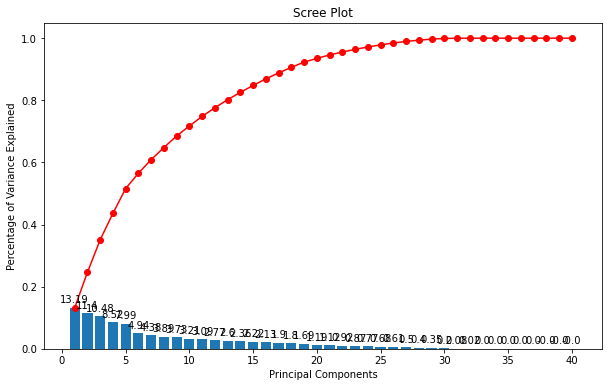

In [13]:
# do pca  for 95% variance
pca_13d= PCA(n_components=13) 
pca_13d.fit(X_train_selected)

X_train_13d = pca_13d.transform(X_train_selected)
X_test_13d = pca_13d.transform(X_test_selected)

pca_13d.plot_scree()

# check auc-roc score with cross validation
model = myLogisticRegression()
# custom_cross_val_score(model, X_train_50d , y_train, cv=5)

Well choose to reduce the dimensions to 13 using PCA in order to gain more that 90% of variance

In [14]:
model = myLogisticRegression()
model.fit(X_train_13d, y_train)
y_test_proba = model.predict_proba(X_test_13d)
y_test_proba = y_test_proba[:, 1]  # keep probabilities for the positive outcome only
prediction_df = pd.DataFrame({'id': x_test_ids, 'expensive': y_test_proba})


In [15]:
display(prediction_df)

,id,expensive
0,6760,0.232440
1,6761,0.871051
2,6762,0.872005
3,6763,0.214826
4,6764,0.869246
...,...,...
3022,9782,0.850720
3023,9783,0.889504
3024,9784,0.885722
3025,9785,0.206005


In [16]:
prediction_df.to_csv('data/predictions.csv', index=False)